# Chapter 3: Defining computation

This notebook contains code related to **Chapter 3: Defining Computation**.

In [3]:
# utility code 
%run "Utilities.ipynb"
from IPython.display import clear_output
clear_output()

In [188]:
def AND(a,b): return a*b

def OR(a,b): return 1 if a+b else 0

def NOT(a): return 1-a

In [142]:
def EVAL(code,X):
    """Evaluate code on input X."""
    n,m = numinout(code) # helper function - get number of inputs and outputs
    
    vtable = { f"X[{i}]":int(X[i]) for i in range(n)}
    
    for line in code.split("\n"):
        if not line: continue
        foo,op,bar,blah = parseline(line,2) 
        # helper function - split "foo = OP(,blah)" to list ["foo","OP","bar","blah"]
        # 2 is num of arguments to expect: blah is empty if it's missing
        if op=="NOT": vtable[foo] = NOT(vtable[bar])
        if op=="AND": vtable[foo] = AND(vtable[bar],vtable[blah])
        if op=="OR": vtable[foo] =  OR(vtable[bar],vtable[blah])
    
    return [vtable[f"Y[{j}]"] for j in range(m)]            

In [143]:
code = r"""
t1      = AND(X[0],X[1])
notx0   = NOT(X[0])
t2      = AND(notx0,X[2])
Y[0]    = OR(t1,t2)
"""[1:]

In [144]:
EVAL(code,"010")

[0]

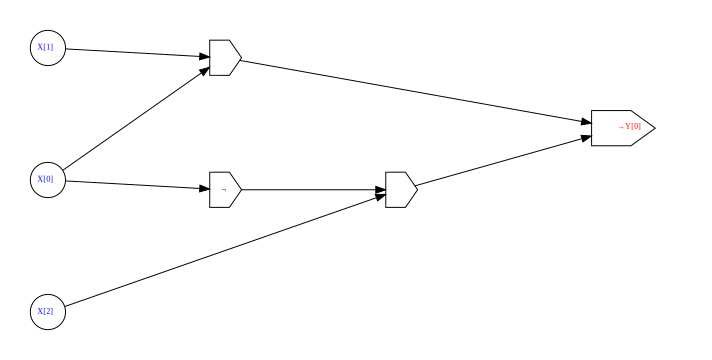

In [145]:
prog2circuit(code)

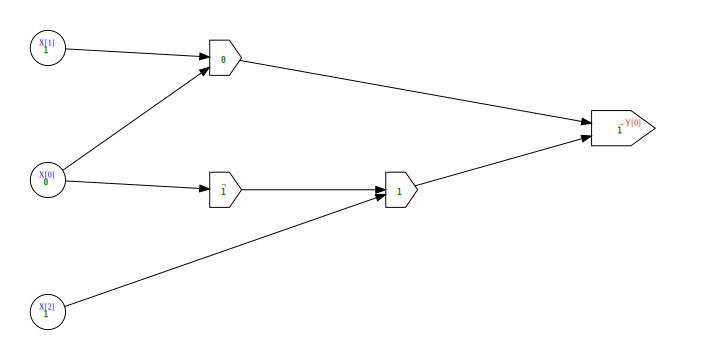

In [146]:
C = prog2circuit(code)
C.render_eval(0,1,1)

In [125]:
def AON2NAND(code):
    """Translate an AON-CIRC program to an equivalent NAND-CIRC program"""
    output = ""
    counter = 0
    for line in code.split("\n"):
        if not line: continue
        foo,op,bar,blah = parseline(line,2) 
        if op=="NOT":
            output += f"{foo} = NAND({bar},{bar})\n"
        if op=="AND": 
            output += f"temp_{counter} = NAND({bar},{blah})\n"
            output += f"{foo} = NAND(temp_{counter},temp_{counter})\n"
            counter +=1
        if op=="OR":
            output += f"temp_{counter} = NAND({bar},{bar})\n"
            output += f"temp_{counter+1} = NAND({blah},{blah})\n"
            output += f"{foo} = NAND(temp_{counter},temp_{counter+1})\n"
            counter +=2
    return output

In [117]:
print(AON2NAND(code))

temp_0 = NAND(X[0],X[1])
t1 = NAND(temp_0,temp_0)
notx0 = NAND(X[0],X[0])
temp_1 = NAND(notx0,X[2])
t2 = NAND(temp_1,temp_1)
temp_2 = NAND(t1,t1)
temp_3 = NAND(t2,t2)
Y[0] = NAND(temp_2,temp_3)



In [181]:
def BIG1(a,b):
    t = NOT(b)
    return OR(a,t)

def BIG2(X):
    """Input is X[0]...X[3] which we consider as two three-bit numbers A and B. We return 1 iff A>B"""
    y1 = BIG1(X[0],X[2])
    n1 = BIG1(X[2],X[0])
    y2 = BIG1(X[1],X[3])
    t  = AND(y2,n1)
    return OR(y1,t)

In [191]:
def aon2code(f,n):
    X = [f"X[{i}]" for i in range(n)]
    counter = 0
    code = ""
    def getvar():
        nonlocal counter
        counter +=1
        return f"temp_{counter}"
    def op(name,a,b=None): 
        nonlocal code
        v = getvar()
        if b: 
            code += f"\n{v} = {name}({a},{b})"
        else:
            code += f"\n{v} = {name}({a})"
        return v
    
    global AND
    global OR
    global NOT
    _ = AND
    __ = OR
    ___ = NOT
    try:
        AND = lambda a,b: op("AND",a,b)
        OR = lambda a,b: op("OR",a,b)
        NOT = lambda a: op("NOT",a)
        v= f(X)
    finally:
        AND = _ 
        OR  = __ 
        NOT = ___
    code = code.replace(v,"Y[0]")
    return code
    

In [193]:
code = aon2code(BIG2,4)
print(code)


temp_1 = NOT(X[2])
temp_2 = OR(X[0],temp_1)
temp_3 = NOT(X[0])
temp_4 = OR(X[2],temp_3)
temp_5 = NOT(X[3])
temp_6 = OR(X[1],temp_5)
temp_7 = AND(temp_6,temp_4)
Y[0] = OR(temp_2,temp_7)


In [190]:
BIG2([1,0,0,1])

1

In [179]:
BIG1(1,0)

1

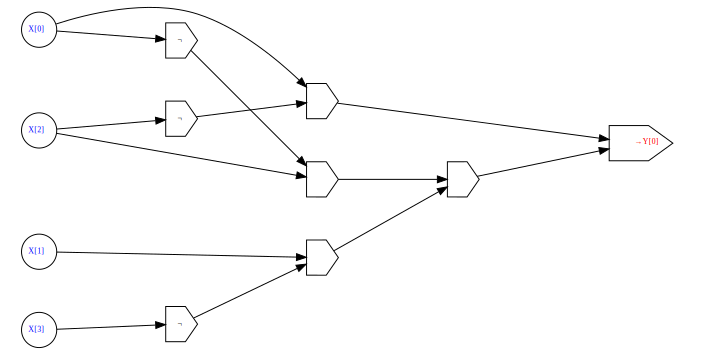

In [195]:
C = prog2circuit(code)
C

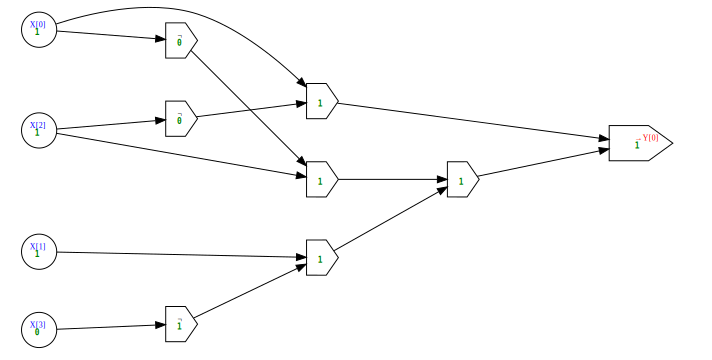

In [196]:
C.render_eval(1,1,1,0)

In [2]:
# Neural net activation functions

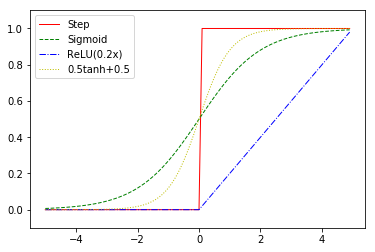

In [13]:
import numpy as np
import matplotlib.pylab as plt


def step(x):
    return np.array(x > 0, dtype=np.int)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, 0.2*x)

def mytanh(x):
    return 0.5*np.tanh(x)+0.5

x = np.arange(-5.0, 5.0, 0.1)
y_step = step(x)
y_sigmoid = sigmoid(x)
y_relu = relu(x)
y_tanh = mytanh(x)

plt.plot(x, y_step, label='Step', color='r', lw=1, linestyle=None)
plt.plot(x, y_sigmoid, label='Sigmoid', color='g', lw=1, ls='--')
plt.plot(x, y_relu, label='ReLU(0.2x)', color='b', lw=1, linestyle='-.')
plt.plot(x, y_tanh, label='0.5tanh+0.5',color='y',lw=1,linestyle=':')
plt.ylim(-0.1, 1.1)
plt.legend()
plt.show()